In [1]:
from sklearn.model_selection import train_test_split
from src.baseline_experiments import *
import pandas as pd
import sklearn
import numpy as np
import glob
from mountaineer import Mountaineer
from gale import create_mapper, bootstrap_mapper_params

## Import Diabetes dataset

In [2]:
np.random.seed(42)
torch.manual_seed(42)

df = pd.read_csv("./dataset/diabetes.csv")
df.drop(columns=["p_id"], inplace=True)

In [3]:
X = df.drop(columns=["diabetes"])
y = df["diabetes"]

## Train a neural network model with two hidden layers

In [4]:
batch_size = 16
num_epochs = 80
learning_rate = 4e-3
N = 100
shap_sample_size = 10
#possible blur/mean/zero
imputation_typ = 'blur'


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
X_train_tens = torch.tensor(X_train.to_numpy()).float()
X_test_tens = torch.tensor(X_test.to_numpy()).float()

In [6]:
unique, counts = np.unique(y_train, return_counts=True)
    
averaging = 'binary'
y_train_tens = torch.tensor(y_train.to_numpy()).view(-1, 1).float()
output_dim = 1

In [7]:
device = torch.device("cpu")

dataset_tens = torch.utils.data.TensorDataset(X_train_tens, y_train_tens)
train_iter = torch.utils.data.DataLoader(dataset_tens, batch_size, shuffle=False)

print("Try to load the model..")
model = nn_model.get_model(device, train_iter, X_train.shape[1], output_dim, averaging, learning_rate, num_epochs)

Try to load the model..
Train model
Epoch 020: | Loss: 0.30523 | Acc: 86.654 | F1: 79.20633
Epoch 040: | Loss: 0.28288 | Acc: 90.462 | F1: 85.07238
Epoch 060: | Loss: 0.20930 | Acc: 92.577 | F1: 88.17563
Epoch 080: | Loss: 0.18856 | Acc: 92.077 | F1: 87.61079
Set to eval


In [8]:
X_test_tens = torch.tensor(X_test.to_numpy()).float()

X_test_c, Y_test_c = get_correct_predictions(model,X_test.reset_index(drop=True),X_test_tens,y_test.reset_index(drop=True),averaging)
X_test_c_tens = torch.from_numpy(X_test_c.to_numpy(dtype=np.float32))

X_test of correct predictions shape: (146, 8)
Y_test of correct predictions shape: (146,)
Label in Y_test of correct predictions ratio: 
 [[ 0 98]
 [ 1 48]]


## Use the sigmoid function as the prediction probability function for Mapper

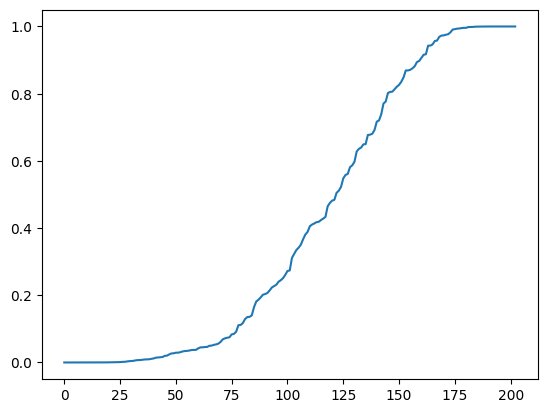

In [9]:
predictions = torch.sigmoid(model(X_test_tens)).detach().numpy()
plt.plot(np.sort(predictions.flatten()))

## Compute the Explanations of (IntGrad, SHAP, DeepLIFT) $\times$ (Zero, Max Distances, Uniform, Gaussian, Train)-Baselines (15 explanation outputs in total)


In [10]:
print("Loading all baselines..")
bun = BaselineUtilTensor()
black_baseline = bun.create_black_baseline(X)
uniform_baseline = bun.create_uniform_baseline(X)
gaussian_baseline = bun.create_gaussian_baseline(X, 0.5)
train_baseline = bun.create_train_baseline(X)

Loading all baselines..


In [11]:
explanations = {}
methods = ['IG','DeepSHAP','DeepLIFT']
target = None
for method in methods:
    bb_attr, mdb_attr, ub_attr, gb_attr, tb_attr = get_attr_scores(method, X_test_tens, None, black_baseline,uniform_baseline,gaussian_baseline, train_baseline, model,X.min(), X.max(), X.columns)
    explanations[method] = [bb_attr, mdb_attr, ub_attr, gb_attr, tb_attr]


Start integrated gradients for correct predictions with black_baseline
--- '0.18' seconds computation time ---
Start integrated gradients for correct predictions with max_dist_baseline
--- '0.83' seconds computation time ---
Start integrated gradients for correct predictions with uniform_baseline
--- '1.70' seconds computation time ---
Start integrated gradients for correct predictions with gaussian_baseline
--- '1.84' seconds computation time ---
Start integrated gradients for correct predictions with train_baseline
--- '1.78' seconds computation time ---
Start DeepSHAP for correct predictions with black_baseline
--- '0.20' seconds computation time ---
Start DeepSHAP for correct predictions with max_dist_baseline
--- '0.29' seconds computation time ---
Start DeepSHAP for correct predictions with uniform_baseline
--- '1.92' seconds computation time ---
Start DeepSHAP for correct predictions with gaussian_baseline
--- '2.01' seconds computation time ---
Start DeepSHAP for correct predic

In [12]:
#baselines = ['zero', 'max distance', 'uniform', 'gaussian', 'trained']

## Creating the mapper outputs

In [13]:
resolutions=[5,10,15,20,25]
gains=[0.1,0.2,0.3,0.4,0.5]
distances=[0.1,0.2,0.3,0.4,0.5]

function = np.array([np.squeeze(i) for i in predictions])

params_boots = {'original': bootstrap_mapper_params(X_test_tens.numpy(), function, resolutions, gains, distances, ci=0.95, n=100),
                'IG':       bootstrap_mapper_params(explanations['IG'][4], function, resolutions, gains, distances, ci=0.95, n=100),
                'DeepSHAP': bootstrap_mapper_params(explanations['DeepSHAP'][4], function, resolutions, gains, distances, ci=0.95, n=100),
                'DeepLIFT': bootstrap_mapper_params(explanations['DeepLIFT'][4], function, resolutions, gains, distances, ci=0.95, n=100)
                }

In [14]:
for mode in params_boots.keys():
    print(f"Params {mode}: {params_boots[mode]}")

Params original: {'stability': 0.020323574542999323, 'components': 3, 'resolution': 10, 'gain': 0.5, 'distance_threshold': 0.5}
Params IG: {'stability': 0.01527225971221935, 'components': 4, 'resolution': 10, 'gain': 0.5, 'distance_threshold': 0.3}
Params DeepSHAP: {'stability': 0.01527225971221935, 'components': 4, 'resolution': 10, 'gain': 0.5, 'distance_threshold': 0.3}
Params DeepLIFT: {'stability': 0.01527225971221935, 'components': 4, 'resolution': 10, 'gain': 0.5, 'distance_threshold': 0.3}


In [15]:
mappers = { 'original': {'fixed_params': create_mapper(X_test_tens.numpy(), function, resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42)),
                        'boots_params': create_mapper(X_test_tens.numpy(), function, resolution=params_boots['original']['resolution'], gain=params_boots['original']['gain'], dist_thresh=params_boots['original']['distance_threshold'])},

            'IG':       {'fixed_params': create_mapper(explanations['IG'][4], function, resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42)),
                        'boots_params': create_mapper(explanations['IG'][4], function, resolution=params_boots['IG']['resolution'], gain=params_boots['IG']['gain'], dist_thresh=params_boots['IG']['distance_threshold']),
                        'boots_params_d': create_mapper(explanations['IG'][4], function, resolution=params_boots['DeepSHAP']['resolution'], gain=params_boots['DeepSHAP']['gain'], dist_thresh=params_boots['DeepSHAP']['distance_threshold'])},

            'DeepSHAP': {'fixed_params': create_mapper(explanations['DeepSHAP'][4], function, resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42)),
                        'boots_params': create_mapper(explanations['DeepSHAP'][4], function, resolution=params_boots['DeepSHAP']['resolution'], gain=params_boots['DeepSHAP']['gain'], dist_thresh=params_boots['DeepSHAP']['distance_threshold'])},
                        
            'DeepLIFT': {'fixed_params': create_mapper(explanations['DeepLIFT'][4], function, resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42)),
                        'boots_params': create_mapper(explanations['DeepLIFT'][4], function, resolution=params_boots['DeepLIFT']['resolution'], gain=params_boots['DeepLIFT']['gain'], dist_thresh=params_boots['DeepLIFT']['distance_threshold'])}
        }

In [16]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:1920px !important; }</style>"))

In [40]:
#visualize
test = Mountaineer()

#list of mapper outputs - minimum 2
mapper_outputs=[ mappers['original']['fixed_params'], mappers['IG']['fixed_params'], mappers['DeepSHAP']['fixed_params'], mappers['DeepLIFT']['fixed_params'],
                mappers['original']['boots_params'], mappers['IG']['boots_params'], mappers['DeepSHAP']['boots_params'], mappers['DeepLIFT']['boots_params']
                ]

explanation_vectors=[X_test_tens.numpy(), explanations['IG'][4], explanations['DeepSHAP'][4], explanations['DeepLIFT'][4],
                     X_test_tens.numpy(), explanations['IG'][4], explanations['IG'][4], explanations['DeepSHAP'][4], explanations['DeepLIFT'][4]
                    ]
explanation_list=[]
for expl in explanation_vectors:
    explanation_list.append(expl.tolist())

labels=['Data_FP', 'IG_FP_GB', 'DS_FP_GB', 'DL_FP_GB', 'Data_BP', 'IG_BP_GB', 'DS_BP_GB', 'DL_BP_GB']

#array of what we want the values to be colored by by default(In this case we are simply passing the lens - ie. Prediction Probabilities)
color_values = [np.array([np.squeeze(i) for i in predictions])]

#column names of the dataframe
column_names= np.array(X.columns)
test.visualize(X_test.to_numpy(),y_test.to_numpy(), mapper_outputs, color_values, explanation_list, column_names, 'UMAP', labels) #Projection method- 'UMAP' or 'TSNE'

In [18]:
#mean of explanation attributions for every feature zero baseline Integrated Gradient
np.max(explanation_vectors[0], axis=0)

array([ 17.   , 196.   , 104.   ,  54.   , 846.   ,  49.7  ,   1.731,
        81.   ], dtype=float32)

In [19]:
#means of explanation attributions for every feature for max distance baseline Integrated Gradients
np.mean(explanation_vectors[1], axis=0)

array([  4.0197043 , 119.83251   ,  68.85714   ,  21.02463   ,
        84.17734   ,  31.002954  ,   0.45182267,  34.802956  ],
      dtype=float32)

In [20]:
#mean of explanation attributions for every feature zero baseline Integrated Gradient
np.median(explanation_vectors[0], axis=0)

array([  3.   , 117.   ,  72.   ,  23.   ,  48.   ,  31.2  ,   0.361,
        31.   ], dtype=float32)

In [21]:
np.min(explanation_vectors[0], axis=0)

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.085, 21.   ],
      dtype=float32)

In [22]:
X_test.describe()

,no_times_pregnant,glucose_concentration,blood_pressure,skin_fold_thickness,serum_insulin,bmi,diabetes pedigree,age
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000
mean,4.019704,119.832512,68.857143,21.024631,84.177340,31.002956,0.451823,34.802956
std,3.422350,32.489473,20.245383,15.851551,121.087719,8.567547,0.279240,12.898714
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,26.800000,0.255000,24.000000
50%,3.000000,117.000000,72.000000,23.000000,48.000000,31.200000,0.361000,31.000000
75%,6.000000,138.000000,80.000000,32.000000,131.000000,36.000000,0.629500,42.500000
max,17.000000,196.000000,104.000000,54.000000,846.000000,49.700000,1.731000,81.000000
